In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Conv2DTranspose, Layer, Conv
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import activations
from tensorflow.python.keras.layers import Conv

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

ImportError: cannot import name 'Conv' from 'tensorflow.keras.layers' (/home/user/.application-data/miniconda3/envs/ml-tensorflow/lib/python3.9/site-packages/tensorflow/keras/layers/__init__.py)

In [2]:
class TiedDense(Layer):
    def __init__(self, tied_layer: Dense, activation: str = None):
        super(TiedDense, self).__init__()
        self.tied_layer = tied_layer
        self.activation = activations.get(activation)

    def build(self, input_dim):
        self.kernel = self.tied_layer.get_weights()[0]

    def call(self, inputs):
        res = tf.matmul(inputs, tf.transpose(self.kernel))
        if self.activation is not None:
            res = self.activation(res)
        
        return res
    
class TiedConv2D(Conv):
    rank,
               filters,
               kernel_size,
               strides=1,
               padding='valid',
               data_format=None,
               dilation_rate=1,
               groups=1,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=True,
               name=None,
               conv_op=None,

In [3]:
class TiedConvolutionalAutoencoder:
    def __init__(self, input_shape, latent_dim, learning_rate=1e-3):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.encoder, self.autoencoder = self.build_autoencoder()

    def build_autoencoder(self):
        # Encoder
        input_layer = Input(shape=self.input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Flatten()(x)
        enc_dense = Dense(self.latent_dim, activation='relu')
        encoded = enc_dense(x)
        encoder = Model(input_layer, encoded)

        # Decoder
        dec_inp = TiedDense(enc_dense, activation='relu')(encoded)
        x = Reshape(encoder.layers[-3].output_shape[1:])(dec_inp)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', use_bias=False)(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2DTranspose(self.input_shape[-1], (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')

        return encoder, autoencoder
        
    def encode(self, x):
        return self.encoder.predict(x)


    def predict(self, x):
        return self.autoencoder.predict(x)

    def train(self, x_train, x_val, epochs, batch_size):
        self.autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, x_val))

In [4]:
# Load and preprocess the CIFAR-100 dataset
(x_train, _), (x_val, _) = cifar100.load_data()
x_train = np.array(x_train).astype('float32') / 255.0
x_val = np.array(x_val).astype('float32') / 255.0

input_shape = x_train.shape[1:]
latent_dim = 128

autoencoder = TiedConvolutionalAutoencoder(input_shape, latent_dim)

2023-11-13 23:08:54.733972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 23:08:54.737250: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-13 23:08:54.737791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 23:08:54.738508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.2415GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 13.41GiB/s

In [5]:
autoencoder.train(x_train, x_val, epochs=10, batch_size=128)

2023-11-13 23:09:10.243270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2023-11-13 23:09:14.188042: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2023-11-13 23:09:17.885880: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-13 23:09:17.927994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2901210000 Hz


Epoch 1/10


2023-11-13 23:09:20.654734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-11-13 23:09:21.630346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


391/391 [==============================] - ETA: 0s - loss: 0.0406

2023-11-13 23:10:02.208800: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.
2023-11-13 23:10:04.667756: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.


391/391 [==============================] - 51s 110ms/step - loss: 0.0405 - val_loss: 0.0197
Epoch 2/10
391/391 [==============================] - 33s 85ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 3/10
391/391 [==============================] - 33s 84ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 4/10
391/391 [==============================] - 34s 86ms/step - loss: 0.0143 - val_loss: 0.0135
Epoch 5/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0136 - val_loss: 0.0130
Epoch 6/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 7/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 9/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0123 - val_loss: 0.0226
Epoch 10/10
391/391 [==============================] - 34s 87ms/step - loss: 0.0141 - val_lo

In [10]:
[layer.name for layer in autoencoder.autoencoder.layers]


['input_1',
 'conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'tied_dense',
 'reshape',
 'up_sampling2d',
 'conv2d_transpose',
 'up_sampling2d_1',
 'conv2d_transpose_1']

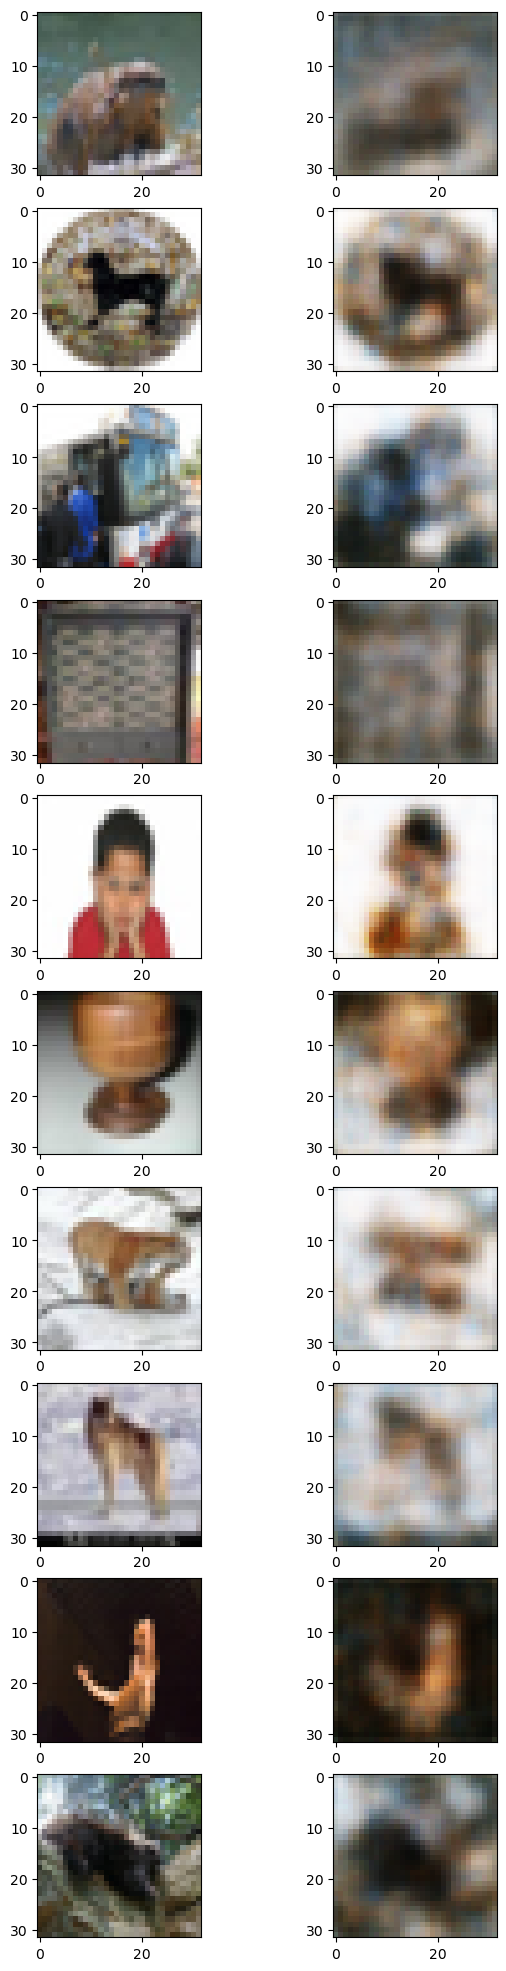

In [6]:
num = 10
fig, axarr = plt.subplots(num, 2, figsize=(7, 25))
idxs = np.random.choice(len(x_val), num)
pred =  autoencoder.predict(x_val[idxs])

for i, idx in enumerate(idxs):
    axarr[i, 0].imshow(x_val[idx])
    axarr[i, 1].imshow(pred[i])

In [2]:
import requests

image_url = 'https://flow-storage-aws.s3.us-east-2.amazonaws.com/backup-nov-23/2022-07-02T20%3A25%3A52.116Z--scaled_image_picker274705461628172101.jpg'

img_data = requests.get(image_url).content
with open('image_name.'+image_url.split('.')[-1], 'wb') as handler:
    handler.write(img_data)